# Chap6 결정 트리

In [5]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 6.1 결정트리 학습과 시각화 (p. 229)

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:,2:] # 꽃잎 길이, 너비(length, width)
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2)

In [9]:
# 그래프 정의를 iris_tree.dot 파일로 출력하여 훈련된 결정 트리를 시각화할 수 있음
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf,
    out_file=os.path.join(IMAGES_PATH,'iris_tree.dot'),
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)

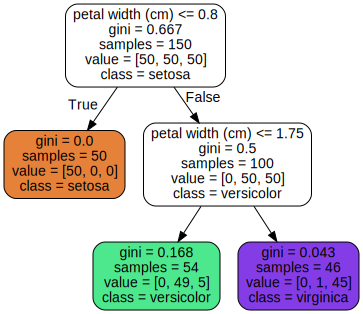

In [13]:
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

- 루트노드에서 시작해서, 해당 노드의 꽃잎 길이가 2.45cm보다 짧은지 검사한다.  
    - `TRUE` : 왼쪽으로 이동. 추가적인 검사X, 리프노드이기 때문(위 그림 참고) → setosa 품종        
    - `FALSE` : 오른쪽으로 이동. 이후 꽃잎 너비가 1.75cm보다 작은지 검사    
        - `TRUE` : versicolor 품종  
        - `FALSE` : virginica 품종
---    
- `gini` : 불순도 측정  
    - `gini=0` : 한 노드의 모든 샘플이 같은 클래스에 속함  

# 6.2 예측하기 (p.231) 

- 결정트리는 데이터 전처리가 거의 필요하지 않는다는 장점이 있다.  
--- 

**불순도 측정 방법**  

- **식 6-1: 지니 불순도**

$$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$$

- **식 6-3: 엔트로피 불순도**(이후 등장)  

$$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$$

## 그림 6-2. 결정 트리의 결정 경계  

그림 저장: decision_tree_decision_boundaries_plot


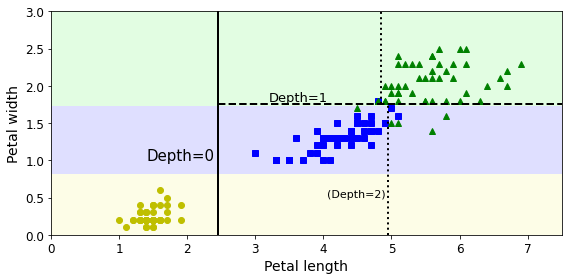

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

- 깊이가 0인 수직선을 기준으로 왼쪽 영역은 순수 노드(Setosa만 존재)이기 때문에 더 나눌 수 없다. 이에 반해 오른쪽 영역은 분류할 수 있어 파선을 기준으로 꽃잎 너비=1.75cm에서 나누어진다.  

## cf 화이트박스 vs 블랙박스  
- **화이트박스 모델**  
    - 직관적이고 결정 방식을 이해하기 쉬운 모델  
    - ex. 결정트리  
    
- **블랙박스 모델**  
    - 성능이 뛰어나고 예측을 만드는 연산 과정을 쉽게 확인할 수 있음  
    - But, 예측이 원인을 파악하기 어려움  
    - ex. 랜덤 포레스트, 신경망  

# 6.3 클래스 확률 추정 (p.234)

- 결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수 있다.(`predict_proba`, `predict` 함수 사용)  
- 아래 예시 : 길이 5cm, 너비 1.5cm → 깊이 2에서 왼쪽 노드  
     - `Setosa` (class=0) : 0%(0/54)  
     - `Versicolor` (class=1) : 90.7%(49/54) => 클래스 = 1추정
     - `Virginica` (class=2) : 9.3%(5/54)  
     - 샘플 수는 위 그림(6.1)에서 참고

In [12]:
print(tree_clf.predict_proba([[5,1.5]])) # 각 클래스 별 추정한 확률 
print(tree_clf.predict([[5,1.5]])) # 추정한 클래스

[[0.         0.90740741 0.09259259]]
[1]


# 6.4 CART 훈련 알고리즘 (p.234)

- 사이킷런은 결정 트리를 훈련시키기 위해 CART 알고리즘을 사용한다.  

**CART(Classification And Regression Tree) 알고리즘**  
- 가장 널리 사용되는 의사결정나무 알고리즘으로, 이름에서도 알 수 있듯이 분류와 회귀 나무에서 모두 사용할 수 있다. 불순도를 측정할 때 목표 변수(y)가 범주형인 경우 지니 지수를 사용하고, 연속형인 경우 분산을 사용하여 이진 분리를 한다.  
- 탐욕적 알고리즘(선택의 순간마다 당장 눈앞에 보이는 최적의 상황만을 쫓아 최종적인 해답에 도달하는 방법)이다.  
- 이 훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고 다음엔 브셋의 서브셋을 누고 이런 식으로 계속 반복한다. 최대 깊이가 되면 중지하거나, 불순도를 줄이는 분할을 찾을 수 없을 때 중지한다.  

[CART, 지니계수 관한 글](https://bigdaheta.tistory.com/27)  
<br>
<br>
**식 6-2: 분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

# 6.5 계산 복잡도 (p.236)

- 계산 복잡도 : $O(n \times mlog(m))$
    - m : 훈련 데이터 수   
    - n : 특성 개수  

# 6.6 지니 불순도 또는 엔트로피 (p.236)

- 불순도 중에서 기본적으로 지니 불순도를 사용하지만(`criterion='gini'`), DecistionTreeClassifier의 `criterion="entropy"`로 지정하여 **엔트로피 불순도**를 사용할 수 있다.  
    - 엔트로피란? 분자의 무질서함을 측정    
    - ex 그림 6-1)  $-\frac{49}{54}log_2({\frac{49}{54}}) -\frac{5}{54}log_2({\frac{5}{54}})$   

    $$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$$ 
--- 
**지니 불순도 vs 엔트로피 불순도**  
- 지니 불순도가 엔트로피 불순도보다 조금 더 계산이 빠르기 때문에 기본값으로 좋다. 
- 그러나 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있는 반면, 엔트로피는 조금 더 균형 잡힌 트리를 만든다.  

# 6.7 규제 매개변수

- 결정 트리는 훈련 데이터에 대한 제약 사항이 거의 없고, 훈련되 기 전 파라미터 수가 결정되지 않아 **비파라미터 모델**에 속한다. 또한 이 모델은 과대적합되기 쉽다.  
- 이와 반대로 선형 모델 같은 **파라미터 모델**은 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고 과대적합될 위험이 줄어든다. 하지만 과소적합될 위험은 커진다.  
- DecisionTreeClassifier에 존재하는 규제매개변수  
    - `min_samples_split` : 분할되기 위해 노드가 가져야 하는 최소 샘플 수  
    - `min_weight_fraction_leaf` : 가중치가 부여된 전체 샘플 수에서의 비율  
    - `max_leaf_nodes` : 리프 노드의 최대 수 
    - `max_features` : 각 노드에서 분할에 사용할 특성의 최대 수  

## 그림 6-3 `min_samples_leaf` 매개변수를 사용한 규제

In [14]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

그림 저장: min_samples_leaf_plot


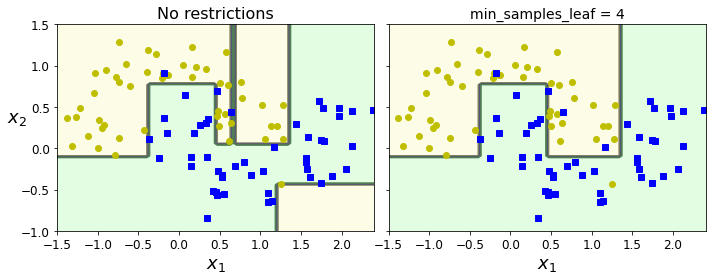

In [15]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42) ## 규제X
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42) ## min_Samples_leaf 규제 
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

- 왼쪽 모델은 확실히 과대적합되었고 오른쪽 모델은 일반화 성능이 더 좋을 것 같다.  

# 6.8 회귀

- 분류 트리와 매우 비슷하지만, 주요한 차이는 <u>각 노드에서 클래스를 예측하는 대신 어떤 값을 예측한다</u>는 점이다.  

In [19]:
# 2차 다항식 훈련세트 + 잡음
np.random.seed(42)

m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X,y)
tree_reg2.fit(X,y)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [26]:
def plot_regression_predictions(tree_reg, X, y, axes=[0,1,-0.2,1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1,1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X,y,"b.")
    plt.plot(x1,y_pred,"r.-",linewidth=2, label=r"$\hat{y}$")

그림 저장: tree_regression_plot


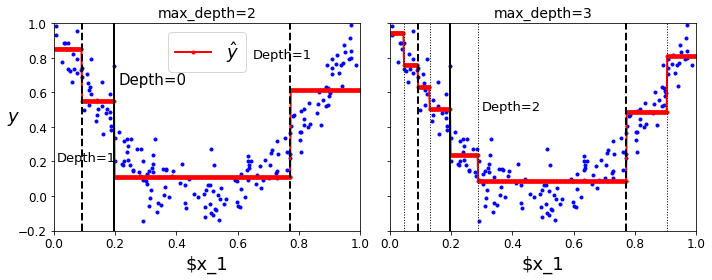

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

# 오른편 그림
plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

- 각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균이 된다. 알고리즘은 예측값과 가능한 한 많은 샘플이 가까이 있도록 영역을 분할한다.  

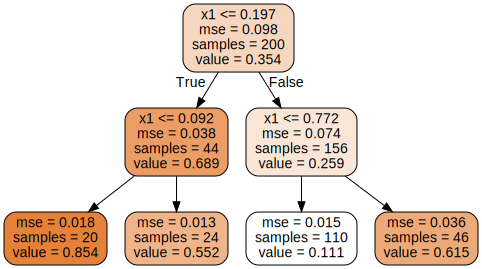

In [28]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

## 회귀모델 규제  

- 결정트리 회귀모델의 규제는 CART 알고리즘이 노드 분할에 사용하는 기준(`criterion`) 하이퍼파라미터에 사용되는 값을 제외하고 분류모델의 경우와 완전히 동일하다. 
    - 분류모델의 비용함수 기준 : 지니 불순도(`gini`) or 엔트로피  
    - 회귀모델의 비용함수 기준 : 평균제곱오차(`mse`), 프리드먼 평균제곱오차(`friedman_mse`), 평균제곱오차(`mae`), 포아송  
---  
- 식 6-4 회귀를 위한 CART 비용 함수  
$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}MSE_\text{left} + \dfrac{m_{\text{right}}}{m}MSE_{\text{right}}\\
&\text{여기에서 }\begin{cases}
MSE_\text{node} = \sum_{i∈node}(\hat{y}_{node}-y^{(i)})^2\\
\hat{y}_\text{node} = \frac{1}{m_{node}}\sum_{i∈node}y^{(i)}
\end{cases}
\end{split}
$

그림 저장: tree_regression_regularization_plot


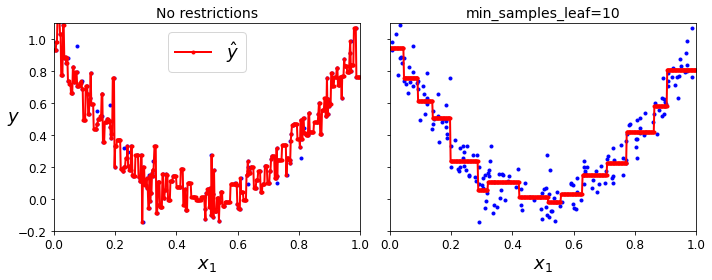

In [29]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10) ## min_samples_leaf 규제
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# 6.9 불안정성

- 결정 트리의 장점이 다양하지만, 계단 모양의 결정 경계를 만들기 때문에 훈련 세트의 회전에 민감하다는 특징이 있다.  
    => <u>훈련 데이터에 있는 작은 변화에도 매우 민감하다</u>

## 회전 민감도 예제 - 1

그림 저장: sensitivity_to_rotation_plot


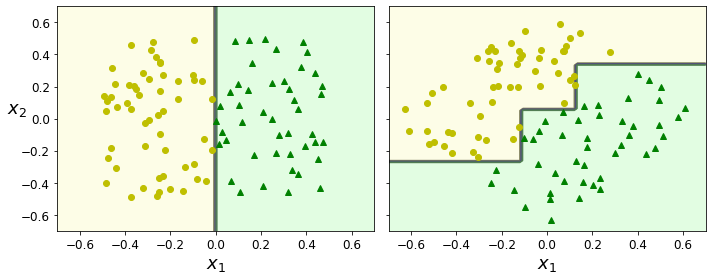

In [30]:
# 2개의 특성(Xs,ys)을 갖는 100가의 훈련 샘플 생성
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2 # 클래스 분류

angle = np.pi / 4 # 회전 각도 45도

# 훈련 세트 회전
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

## 왼쪽
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
## 오른쪾
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

# 그래프
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# 왼쪽 그래프
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
# 오른쪽 그래프
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

- 왼쪽은 쉽게 데이터셋을 구분하지만, 오른쪽(데이터셋을 45도 회전)은 불필요하게 경계선이 구불구불하다.  
- 모두 훈련 세트를 완벽히 학습하지만 오른쪽은 일반화가 잘 되지 않은 것 같다.  
=> 해결 : 훈련 데이터를 더 좋은 방향으로 회전시키는 **PCA**을 사용  

## 회전 민감도 예제 - 2

In [33]:
# 붓꽃 데이터 다시 불러오기
iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

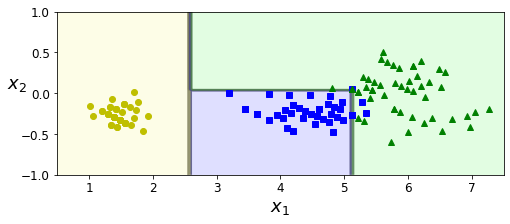

In [34]:
# 시계방향으로 20도 회전
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

## 샘플 민감도 예제  

1. 버시컬러 샘플(y=1) 중 가장 넓은 꽃잎을 가진 샘플 삭제  
2. 결정 트리 훈련  

In [43]:
X[(X[:, 1] == (X[:, 1][y==1].max())) & (y==1)] # 가장 넓은 꽃잎을 갖는 버시컬러 샘플의 특성 확인

array([[4.8, 1.8]])

In [36]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)  # y==2는 버지니카 품종은 그대로 둠.

X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

그림 저장: decision_tree_instability_plot


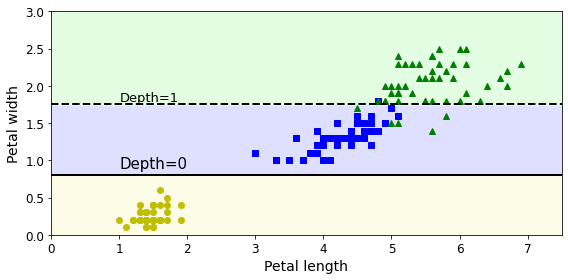

In [37]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

- 아래 그림 6-2 그림과 위 그림의 결정 경계가 많이 달라보인다.  
- 위 그림에서 결정경계 기준값으로 꽃잎의 길이는 전혀 사용되지 않는다.  
<img src="https://t1.daumcdn.net/cfile/tistory/99BC874A5B5892D005" width="500" height="500">